In [147]:
import statistics 
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import bisect

In [148]:
database=pd.read_csv('data.csv')#uploading the database
database_ini=database.round(2) #roundin upto 2 decimal points
database_ini['log_Depth'] = np.log(database_ini['Depth']) #log values for fitting model
database_ini['log_Width'] = np.log(database_ini['Width'])  #log values for fitting model
database_ini['log_Amplitude'] = np.log(database_ini['Amplitude'])  #log values for fitting model
database_ini['log_Wavelength'] = np.log(database_ini['Wavelength'])  #log values for fitting model
prediction = pd.DataFrame(columns=['Depth','Width','Amplitude','Wavelength'], index=['P90','P50','P10'])#dataframe for results
river_type=['UNKNOWN']#initiate river type list
env=[]#initiate river type list

Avaliable river 'Types': 'MEANDERING',  'LOW SINUSITY', 'BRAIDED', 'UNKNOWN'

Avaliable 'Environment': 'FLUVIAL UNDEFINED','TIDAL','PERENNIAL','PERENNIAL SUBHUMID','LACUSTRINE TURBIDITE'

In [149]:
option=input('River type for analysis :')
env_option=input('Environment for analysis :')

River type for analysis :MEANDERING
Environment for analysis :FLUVIAL UNDEFINED


In [150]:
river_type.append(option.upper()) # finalizing river type list
env.append(env_option.upper()) # finalizing river type list
database_ini_1=database_ini.loc[database_ini['Type'].isin(river_type)] # soritng initial list by river type
database_fn=database_ini_1.loc[database_ini_1['Environment'].isin(env)] # sorting inital list by environment
channel_parameters=database_fn.loc[:, 'Width':'Wavelength'] # creating subset of the data for box and whiskers plot

In [151]:
"""This method is described in paper 'Using method described in Bride and Tye, AAPG bulletin, V.84, 2000' for
measurement of channel thickness based on cross bed thickness measurement"""
def thickness(mean_thick):
    beta=mean_thick/1.8
    hm=2.22*beta**1.32
    ch_thick=11.6*hm**0.84
    return(ch_thick)

In [152]:
"""Appendix 56 from Basin Analysis textbook by Allen and Allen (2013)"""
# Decompaction function to be used to convert subsurface thickness into surface reading
def compaction(y2a,y1,y2,y1a,phi,c):
    LHS = y2a - y1a
    RHS = y2 - y1 - (phi/c)*(np.exp(-c*y1)-np.exp(-c*y2)) + (phi/c)*(np.exp(-c*y1a)-np.exp(-c*y2a))
    return LHS - RHS

In [153]:
# functions for standard scatterplot preparation for user
def scatterplot(x_dim, y_dim, df=database_fn):  
    x = df[x_dim]
    y = df[y_dim]
    colours={'Fielding and Crane, 1987':'red','Leeder, 1973':'green','Colombera et al., 2018':'navy',"Colombera et al., 2013":'navy','Leopold and Wolman, 1960':'cyan','Hove et al., 2017':'magenta',"Leuven et al., 2018":'mediumspringgreen',"Sidorchuk et al., 2013":'tan',"Marani et al., 2002":'coral',"Zhang, 2014":'lime','AAPG outcrop':'slategrey',"Martin et al., 2018":'darkgoldenrod',"Kastner et al., 2017":'pink'}
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(x, y,alpha=0.70,color=[colours[r] for r in database_fn['Source']])
    ax.grid(which='major',color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(which='minor',color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(x_dim,fontsize=15)
    plt.ylabel(y_dim,fontsize=15)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colours.values()]
    plt.legend(markers, colours.keys(), numpoints=1)
    plt.show()
# functions for standard box and whiskers plot preparation for individual parameters
def box_plot(x_dim, df=database_fn): 
    x = df[x_dim].dropna()
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.boxplot(x,showfliers=False)
    ax.set_xlabel(x_dim)
    ax.set_ylabel('Values')
    plt.show()
def histogram(x_dim, df=database_fn): 
    x = df[x_dim].dropna()
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(x,bins=20,color = "green")
    ax.set_xlabel(x_dim)
    ax.set_ylabel('Number')
    plt.show()
def x_check(x_dim,y_dim,df1=database_fn,df2=prediction):
    x1=df1[x_dim]
    y1=df1[y_dim]
    x2=df2[x_dim]
    y2=df2[y_dim]
    colours={'Data':'navy','Prediction':'red'}
    plt.figure(figsize=(12, 6), dpi=80)
    plt.scatter(x1,y1,color = colours['Data'],alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(x_dim,fontsize=15)
    plt.ylabel(y_dim,fontsize=15)
    plt.scatter(x2,y2, color = colours['Prediction'])
    plt.grid(which='major',color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.grid(which='minor',color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colours.values()]
    plt.legend(markers, colours.keys(), numpoints=1)
    plt.show()

In [154]:
# function to calculate channel parameters if no information apart from sand thickness is known
"""The geometry of fluvial channel bodies: Empirical characterization and implications for object-based 
models of the subsurface, Colombera et al., 2018, AAPG Bulletin, doi: 10.1306/10031817417"""
def colombera(df): # to cross check with prediction dataframe
    print('\033[1m'+ '\033[94m'+'The geometry of fluvial channel bodies: Empirical characterization and implications for object-based models of the subsurface, Colombera et al., 2018, AAPG Bulletin, doi: 10.1306/10031817417'+'\033[0m')
    df['depth']=df['Depth']
    df['width']=23.42*np.power(df['Depth'],1.13)
    df['amplitude']=2.39*np.power(df['width'],0.83)
    df['wavelength']=63.35*np.power(df['width'],0.68)
    df2=df.loc[:, 'depth':'wavelength']
    df2=df2.round(2)
    return(df2)
def colombera_min_max(x): # to cross check for a single channel depth value
    print('\033[1m'+ '\033[94m'+'The geometry of fluvial channel bodies: Empirical characterization and implications for object-based models of the subsurface, Colombera et al., 2018, AAPG Bulletin, doi: 10.1306/10031817417'+'\033[0m')
    p50_width=23.42*np.power(x,1.13)
    min_width=0.55*np.power(p50_width,0.96)
    print('\033[92m'+'Min channel width: '+'\033[0m',np.round(min_width,2),'\033[92m'+" Data status: n = 1730; N = 33"+'\033[0m')
    max_width=6.35*np.power(p50_width,0.89)
    print('\033[92m'+'Max channel width: '+'\033[0m',np.round(max_width,2),'\033[92m'+" Data status: n = 1730; N = 33"+'\033[0m')
    p50_amplitude=2.39*np.power(p50_width,0.83)
    min_amplitude=0
    print('\033[92m'+'Min channel amplitude: '+'\033[0m',min_amplitude,'\033[92m'+" Data status: n = 449; N = 17"+'\033[0m')
    max_amplitude=5.84*np.power(p50_amplitude,0.95)
    print('\033[92m'+'Max channel amplitude: '+'\033[0m',np.round(max_amplitude,2),'\033[92m'+" Data status: n = 449; N = 17"+'\033[0m')
    p50_wavelength=63.35*np.power(p50_width,0.68)
    min_wavelength=0.03*np.power(p50_wavelength,1.23)
    print('\033[92m'+'Min channel wavelength: '+'\033[0m',np.round(min_wavelength,2),'\033[92m'+" Data status: n = 403; N = 17"+'\033[0m')
    max_wavelength=2.98*p50_wavelength+5214
    print('\033[92m'+'Max channel wavelength: '+'\033[0m',np.round(max_wavelength,2),'\033[92m'+" Data status: n = 403; N = 17"+'\033[0m')

In [155]:
# Some constants used for calcultion
c_sand = 0.27  ## per km porosity-depth coefficient for sand
phi_sand = 0.49   # initial sand porosity
y1a = 0.0   #Decompacted to surface

In [156]:
# User need to put the number of x-beds measurements and the values as well
x_beds = [] 
n = int(input("Enter number of cross bed thickness measurements : ")) 
for i in range(0, n): 
    measure = float(input()) 
    x_beds.append(measure)

Enter number of cross bed thickness measurements : 0


In [157]:
if n<=1:
    ch_thick=input('Channel thickness in meters: ')
else:
    std_thick=statistics.stdev(x_beds)
    mean_thick=statistics.mean(x_beds)
    if std_thick/mean_thick>=0.58 and std_thick/mean_thick<=1.18: #the described is only valid for this limit values
        ch_thick=thickness(mean_thick)
    else:
        print('Provided data not within limit values, please input the thickness data')
        ch_thick=input('Channel thickness in meters: ')

Channel thickness in meters: 11.2


In [158]:
depth = input('Channel top depth in meters: ')

Channel top depth in meters: 2345


In [159]:
y2=float(ch_thick)+float(depth)
y2=float(y2)/1000
y1=float(depth)/1000

In [160]:
# contstant C_sand,phi_sand and yla used in this calculation
compaction_1 = functools.partial(compaction, y1=y1, y2=y2, y1a=y1a, phi=phi_sand, c=c_sand)
y2a = bisect(compaction_1,y1a,y1a+3*(y2-y1))

In [161]:
thickness=round((y2a-y1a)*1000)

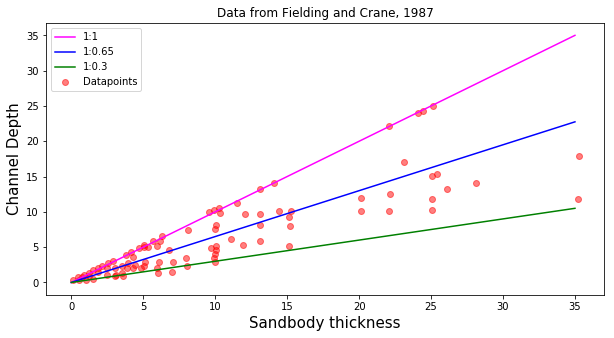

In [162]:
# plots for explaining creating the limiting cases in channel depth values
"""Data from 'Fielding, C.R. and Crane, R.C., 1987. An Application of Statistical Modelling to the 
prediction of Hydrocarbon Recovery Factors in Fluvial Reservoir Sequences. S.E.P.M. p321-327'"""
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(database['Sandbody thickness'], database['Depth'], c='red',alpha=0.50,label='Datapoints') # data scatterplot
slope1,slope2,slope3 = 1,0.65,0.3 # definning limiting slopes
x_0,y_0,x_1 = 0,0,35
y_1 = slope1*(x_1 - x_0) + y_0 # creating bounding lines
y_2 = slope2*(x_1 - x_0) + y_0 # creating bounding lines
y_3 = slope3*(x_1 - x_0) + y_0 # creating bounding lines
ax.plot([x_0, x_1], [y_0, y_1], c='magenta',label='1:1') # plotting bounding lines
ax.plot([x_0, x_1], [y_0, y_2], c='b',label='1:0.65') # plotting bounding lines
ax.plot([x_0, x_1], [y_0, y_3], c='g',label='1:0.3') # plotting bounding lines
plt.title('Data from Fielding and Crane, 1987')
plt.xlabel('Sandbody thickness',fontsize=15)
plt.ylabel('Channel Depth',fontsize=15)
plt.legend()
plt.show()

In [163]:
depth_input=[np.round(0.3*thickness,2),np.round(0.65*thickness,2),thickness] #P90,P50,P10 channel depth values from above plot
prediction['Depth']=depth_input # updating the depth values in prediction dataframe
prediction['log_Depth'] = np.log(prediction['Depth'])

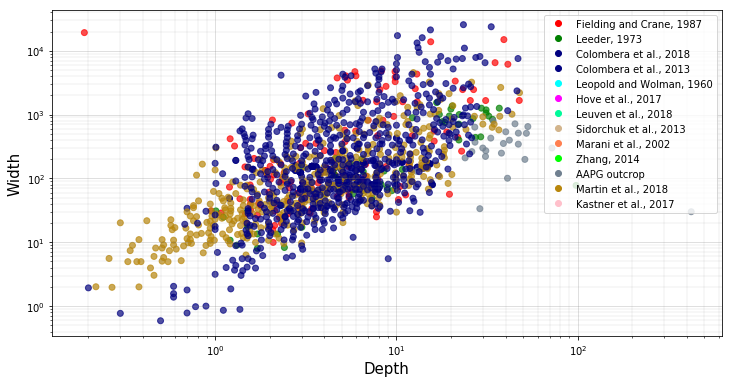

In [164]:
scatterplot('Depth','Width') # change parameters for individual parameter plots

,Width,Depth,Amplitude,Wavelength
count,2335.000000,1460.000000,811.000000,1096.000000
mean,595.335370,52.135473,2297.459051,3149.473011
std,1547.219527,439.132638,7900.679933,6299.923855
min,0.590000,0.190000,10.170000,9.520000
25%,77.920000,2.470000,143.840000,656.277500
50%,190.530000,4.840000,458.830000,1644.350000
75%,584.525000,9.745000,1780.750000,4209.922500
max,25595.480000,10520.830000,189732.830000,166530.010000


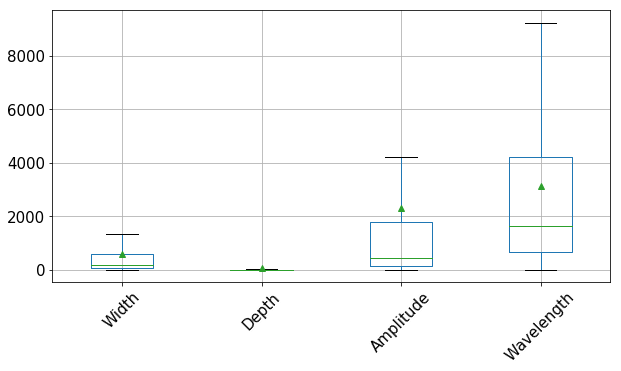

In [165]:
#channel parameters box and whiskers plot
channel_parameters.boxplot(figsize=(10, 5),showfliers=False,rot=45, fontsize=15,showmeans=True) 
channel_parameters.describe()

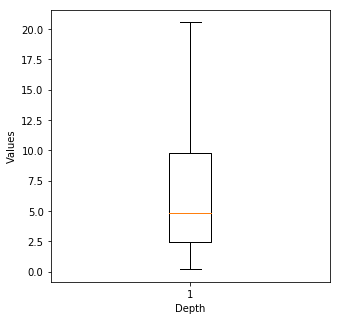

In [166]:
box_plot('Depth') #change channel parameters for individual box and whiskers plot

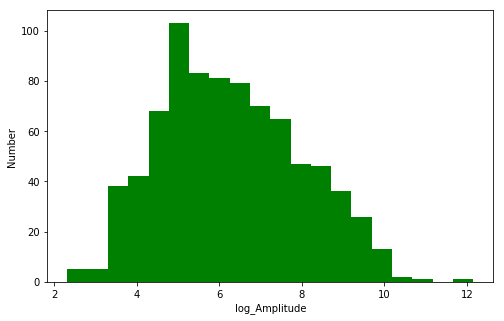

In [167]:
histogram('log_Amplitude') # change channel parameters to see corresponding plots

                            OLS Regression Results                            
Dep. Variable:              log_Width   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     935.7
Date:                Mon, 15 Jun 2020   Prob (F-statistic):          2.93e-157
Time:                        12:42:18   Log-Likelihood:                -2309.6
No. Observations:                1380   AIC:                             4623.
Df Residuals:                    1378   BIC:                             4634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2383      0.064     50.935      0.0

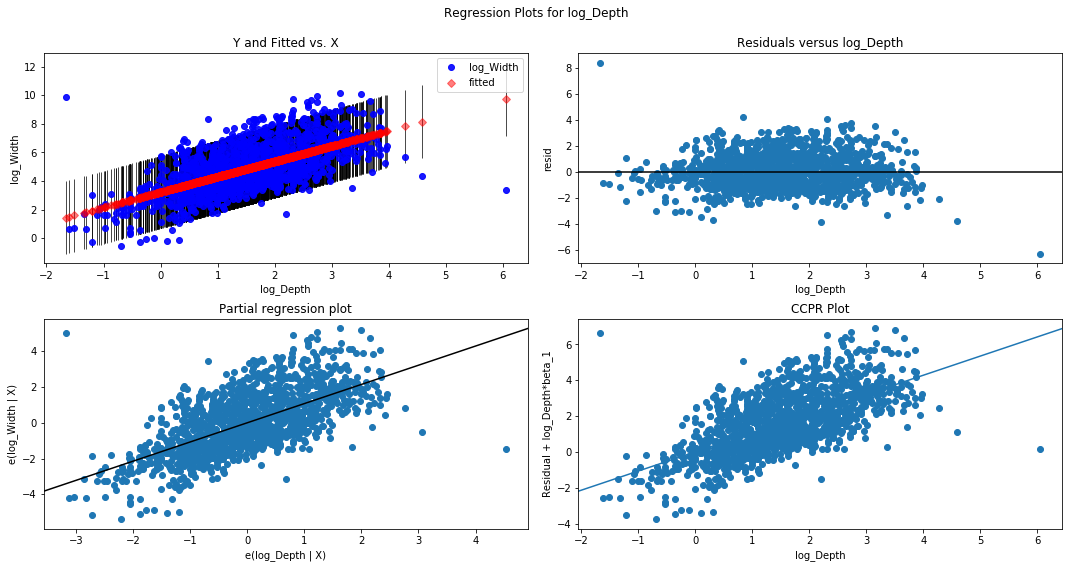

In [168]:
if database_fn['Depth'].count()>=5:
    f1 = 'log_Width~log_Depth'   # fitting formula for width value from depth
    width_model= ols(formula=f1, data=database_fn).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(width_model,'log_Depth', fig=fig) 
    print(width_model.summary())
else:
    f1 = 'log_Width~log_Depth'   # fitting formula for width value from depth
    width_model= ols(formula=f1, data=database_ini).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(width_model,'log_Depth', fig=fig) 
    print(width_model.summary())

In [169]:
prediction['log_Width']=width_model.predict(prediction) # updating the width values in prediction dataframe
prediction['Width']=np.round(np.exp(prediction['log_Width']),2)

                            OLS Regression Results                            
Dep. Variable:          log_Amplitude   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     585.3
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           1.26e-87
Time:                        12:42:19   Log-Likelihood:                -620.88
No. Observations:                 531   AIC:                             1246.
Df Residuals:                     529   BIC:                             1254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1358      0.177      6.411      0.0

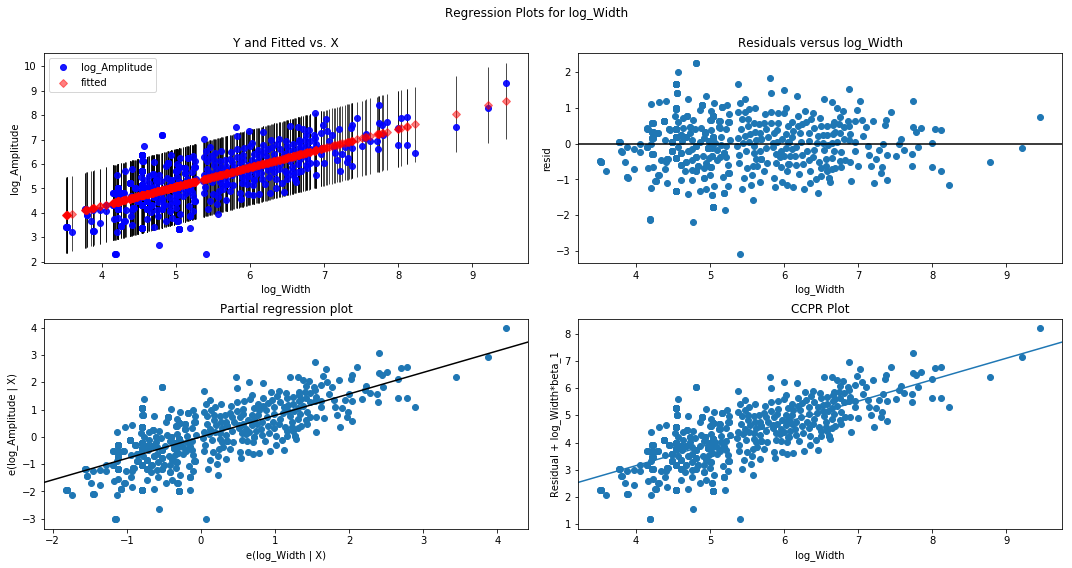

In [170]:
if database_fn['Amplitude'].count()>=5:
    f2 = 'log_Amplitude~log_Width'   # fitting formula for amplitude value from width
    amplitude_model= ols(formula=f2, data=database_fn).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(amplitude_model,'log_Width', fig=fig) 
    print(amplitude_model.summary())
else:
    f2 = 'log_Amplitude~log_Width'   # fitting formula for amplitude value from width
    amplitude_model= ols(formula=f2, data=database_ini).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(amplitude_model,'log_Width', fig=fig) 
    print(amplitude_model.summary())

In [171]:
prediction['log_Amplitude']=amplitude_model.predict(prediction)# updating the amplitude values in prediction dataframe
prediction['Amplitude']=np.round(np.exp(prediction['log_Amplitude']),2)

                            OLS Regression Results                            
Dep. Variable:         log_Wavelength   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1615.
Date:                Mon, 15 Jun 2020   Prob (F-statistic):          1.87e-195
Time:                        12:42:20   Log-Likelihood:                -675.61
No. Observations:                 816   AIC:                             1355.
Df Residuals:                     814   BIC:                             1365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5320      0.109     32.494      0.0

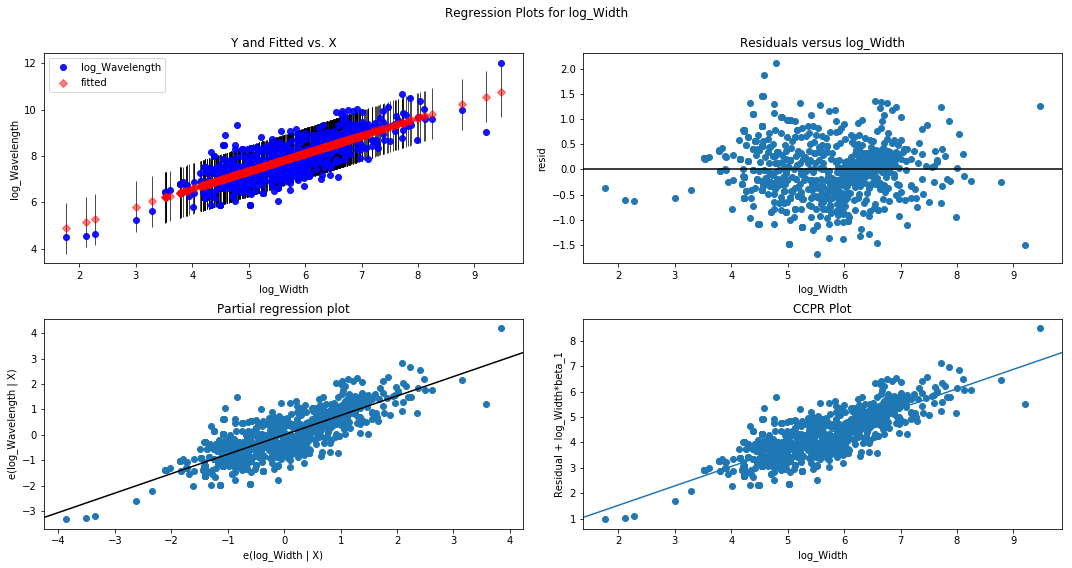

In [172]:
if database_fn['Wavelength'].count()>=5:
    f3 = 'log_Wavelength~log_Width'   # fitting formula for amplitude value from width
    wavelength_model= ols(formula=f3, data=database_fn).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(wavelength_model,'log_Width', fig=fig) 
    print(wavelength_model.summary())
else:
    f3 = 'log_Wavelength~log_Width'   # fitting formula for amplitude value from width
    wavelength_model= ols(formula=f3, data=database_ini).fit()
    fig = plt.figure(figsize =(15,8)) # setting up plots corresponding to the regression used
    fig = sm.graphics.plot_regress_exog(wavelength_model,'log_Width', fig=fig) 
    print(wavelength_model.summary())

In [173]:
prediction['log_Wavelength']=wavelength_model.predict(prediction)# updating the wavelength values in prediction dataframe
prediction['Wavelength']=np.round(np.exp(prediction['log_Wavelength']),2)
prediction=prediction.loc[:, 'Depth':'Wavelength'] #removing logarithimic calculated values
prediction

,Depth,Width,Amplitude,Wavelength
P90,4.8,136.81,150.16,1462.28
P50,10.4,313.19,288.40,2752.19
P10,16.0,496.83,414.87,3914.71


In [174]:
colombera(prediction) #prediction as per FAKTS database (Colombera, 2018)

The geometry of fluvial channel bodies: Empirical characterization and implications for object-based models of the subsurface, Colombera et al., 2018, AAPG Bulletin, doi: 10.1306/10031817417


,depth,width,amplitude,wavelength
P90,4.8,137.84,142.59,1805.23
P50,10.4,330.24,294.46,3270.05
P10,16.0,537.33,441.06,4553.15


In [175]:
colombera_min_max(10.4) #to check the limiting values as per FAKTS database (Colombera, 2018)

The geometry of fluvial channel bodies: Empirical characterization and implications for object-based models of the subsurface, Colombera et al., 2018, AAPG Bulletin, doi: 10.1306/10031817417
Min channel width:  144.03  Data status: n = 1730; N = 33
Max channel width:  1107.99  Data status: n = 1730; N = 33
Min channel amplitude:  0  Data status: n = 449; N = 17
Max channel amplitude:  1294.17  Data status: n = 449; N = 17
Min channel wavelength:  630.99  Data status: n = 403; N = 17
Max channel wavelength:  14958.74  Data status: n = 403; N = 17


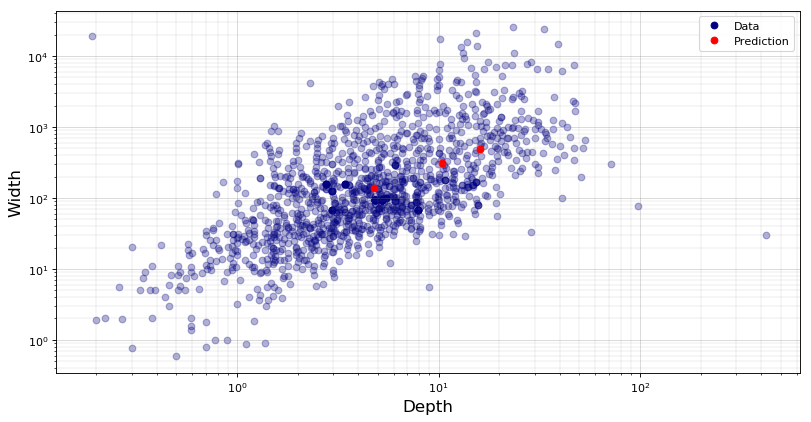

In [176]:
x_check('Depth','Width') #crosscheck results with input data